In [1]:
# ─── Cell 1: Imports & Configuration ─────────────────────────────────────────
import os, sys, pickle, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.cuda.amp as amp
from torch.utils.data import IterableDataset, DataLoader
from torch.optim import AdamW
from transformers import BertTokenizerFast, BertModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from peft import get_peft_model, LoraConfig, TaskType
# Paths
RAW_TEXT = "../data/raw_text.pkl"
SUBJ_DIR  = "../data/subject2"
SAVE_DIR  = "./bert-fmri-finetuned"

# FIXED HYPERPARAMETERS for stable training
BATCH_SIZE    = 8            # Increased from 2 for better statistics
ACCUM_STEPS   = 2            # Reduced from 8 since batch size is larger
EPOCHS        = 5           # Increased from 3 for better convergence
LEARNING_RATE = 1e-6       # Reduced from 2e-5 (10x reduction), 2e-6, 1e-6, 5e-7  5e-5  
MAX_LEN       = 128          # Keep this the same
WEIGHT_DECAY  = 1e-4         # Reduced from 1e-2 for more stable updates
DROPOUT_RATE  = 0.3          # Added dropout rate parameter (raised from 0.2)
USE_L1_LOSS   = True         # Use L1 loss instead of MSE for better stability

# Add new hyperparameters for model architecture
USE_BOTTLENECK = True        # Use a bottleneck layer in the model
BOTTLENECK_SIZE = 512        # Size of bottleneck layer
GRAD_CLIP_VAL = 0.5          # Gradient clipping value (reduced from 0.5)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.empty_cache()
print("Using device:", DEVICE)
print(f"Training config: batch_size={BATCH_SIZE}, accum_steps={ACCUM_STEPS}, learning_rate={LEARNING_RATE}")

Using device: cuda
Training config: batch_size=8, accum_steps=2, learning_rate=5e-07


In [2]:
# ─── Cell 2: Load raw_text.pkl & list stories ─────────────────────────────────
# (If DataSequence is in ridge_utils/, add to path)
repo_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
code_path = os.path.join(repo_root, "code")
if os.path.isdir(code_path):
    sys.path.insert(0, code_path)

with open(RAW_TEXT, "rb") as f:
    raw_texts = pickle.load(f)   # dict: story_id -> DataSequence

# Keep only stories with .npy data
stories = [s for s in raw_texts if os.path.exists(f"{SUBJ_DIR}/{s}.npy")]
print("Total stories available:", len(stories))


Total stories available: 101


/var/tmp/ipykernel_100080/1766332120.py:9: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  raw_texts = pickle.load(f)   # dict: story_id -> DataSequence


In [3]:
# ─── Cell 3: Compute y_mean, y_std over training set with fix ──────────────────────
def get_trimmed_Y(seq, subj_dir, sid):
    Y = np.load(f"{subj_dir}/{sid}.npy", mmap_mode="r")
    TR = float(np.mean(np.diff(seq.tr_times)))
    start = int(math.ceil(5.0 / TR))
    end = -int(math.ceil(10.0/ TR))
    return Y[start:end]

# Split for mean/std computation
train_ids, test_ids = train_test_split(stories, test_size=0.2, random_state=42)

sum_y = None
sum_y2 = None
count = 0
for sid in train_ids:
    seq = raw_texts[sid]
    Y_trim = get_trimmed_Y(seq, SUBJ_DIR, sid)
    
    # Check for NaNs in the data
    if np.isnan(Y_trim).any() or np.isinf(Y_trim).any():
        print(f"WARNING: NaNs/Infs detected in story {sid}, replacing with zeros")
        Y_trim = np.nan_to_num(Y_trim, nan=0.0, posinf=0.0, neginf=0.0)

    
    if sum_y is None:
        V = Y_trim.shape[1]
        sum_y = np.zeros(V, dtype=np.float64)
        sum_y2 = np.zeros(V, dtype=np.float64)
    
    sum_y += Y_trim.sum(axis=0)
    sum_y2 += (Y_trim**2).sum(axis=0)
    count += Y_trim.shape[0]

y_mean = sum_y / count
y_std = np.sqrt(sum_y2/count - y_mean**2)

# CRITICAL FIX: Ensure std is never too small to avoid division problems
MIN_STD = 0.1  # Minimum standard deviation to allow
y_std = np.maximum(y_std, MIN_STD)

# Also check for NaNs in the computed statistics
if np.isnan(y_mean).any():
    print("WARNING: NaNs detected in mean computation, replacing with zeros")
    y_mean = np.nan_to_num(y_mean, nan=0.0)

if np.isnan(y_std).any():
    print("WARNING: NaNs detected in std computation, replacing with ones")
    y_std = np.nan_to_num(y_std, nan=1.0)

print(f"Computed y_mean/std (shape={y_mean.shape}):")
print(f"y_mean range: [{np.min(y_mean)}, {np.max(y_mean)}]")
print(f"y_std range: [{np.min(y_std)}, {np.max(y_std)}]")

Computed y_mean/std (shape=(94251,)):
y_mean range: [-0.022987635020093253, 0.015984447559011735]
y_std range: [0.9701112496330528, 0.9991067582089691]


In [4]:
# ─── Cell 4: IterableDataset + make_pairs ────────────────────────────────────
def make_pairs(seq, Y):
    TR = float(np.mean(np.diff(seq.tr_times)))
    start = int(math.ceil(5.0 / TR))
    end   = -int(math.ceil(10.0/ TR))
    for t, y_row in zip(seq.tr_times[start:end], Y[start:end]):
        mask = (seq.data_times >= t-TR/2) & (seq.data_times < t+TR/2)
        words = [seq.data[i] for i in np.where(mask)[0]]
        text  = " ".join(words) or "[PAD]"
        yield text, y_row

class FMRIIterableDataset(IterableDataset):
    def __init__(self, raw_texts, subj_dir, story_ids, tokenizer, max_len, y_mean, y_std):
        self.raw_texts = raw_texts
        self.subj_dir   = subj_dir
        self.story_ids = story_ids
        self.tok       = tokenizer
        self.max_len   = max_len
        self.y_mean    = torch.tensor(y_mean, dtype=torch.float)
        self.y_std     = torch.tensor(y_std,  dtype=torch.float)

    def __iter__(self):
        random.shuffle(self.story_ids)
        for sid in self.story_ids:
            seq = self.raw_texts[sid]
            Y = np.load(f"{self.subj_dir}/{sid}.npy", mmap_mode="r")

            # Clean Y to remove NaNs/Infs before use
            if np.isnan(Y).any() or np.isinf(Y).any():
                print(f"🚫 NaN/Inf found in fMRI data for story {sid}, applying nan_to_num")
                Y = np.nan_to_num(Y, nan=0.0, posinf=0.0, neginf=0.0)

            for text, y_row in make_pairs(seq, Y):
                enc = self.tok(
                    text,
                    truncation=True,
                    padding="max_length",
                    max_length=self.max_len,
                    return_tensors="pt"
                )
                y = (torch.tensor(y_row, dtype=torch.float) - self.y_mean) / self.y_std
                yield {
                  "input_ids":      enc.input_ids.squeeze(0),
                  "attention_mask": enc.attention_mask.squeeze(0),
                  "y":              y
                }

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained("google-bert/bert-base-uncased")


In [5]:
# ─── Cell 5: Create DataLoaders ───────────────────────────────────────────────
train_ds = FMRIIterableDataset(raw_texts, SUBJ_DIR, train_ids,
                               tokenizer, MAX_LEN, y_mean, y_std)
test_ds  = FMRIIterableDataset(raw_texts, SUBJ_DIR, test_ids,
                               tokenizer, MAX_LEN, y_mean, y_std)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    num_workers=0,    # safe for large data
    pin_memory=True
)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    num_workers=0,
    pin_memory=True
)
print("DataLoaders ready.")


DataLoaders ready.


In [6]:
# ─── Data Diagnosis Cell ─────────────────────────────────────────────────────
# Add this cell between Cell 5 and Cell 6 to diagnose the data issues

# Check for NaNs or extreme values in the input data and targets
def diagnose_data(loader, max_batches=10):
    """Check data for potential issues"""
    print("Diagnosing data issues...")
    batch_count = 0
    input_nans = False
    target_nans = False
    extreme_values = False
    
    y_stats = {
        'min': float('inf'),
        'max': float('-inf'),
        'mean': 0,
        'count': 0
    }
    
    for batch in loader:
        batch_count += 1
        if batch_count > max_batches:
            break
            
        # Check input IDs
        if torch.isnan(batch["input_ids"]).any():
            input_nans = True
            print("WARNING: NaN detected in input_ids")
            
        # Check attention mask
        if torch.isnan(batch["attention_mask"]).any():
            input_nans = True
            print("WARNING: NaN detected in attention_mask")
            
        # Check target values
        y = batch["y"]
        if torch.isnan(y).any():
            target_nans = True
            print(f"WARNING: NaN detected in targets (batch {batch_count})")
            
        # Check for extreme values in targets
        y_min = torch.min(y).item()
        y_max = torch.max(y).item()
        y_mean = torch.mean(y).item()
        
        y_stats['min'] = min(y_stats['min'], y_min)
        y_stats['max'] = max(y_stats['max'], y_max)
        y_stats['mean'] += y_mean
        y_stats['count'] += 1
        
        if abs(y_min) > 1e3 or abs(y_max) > 1e3:
            extreme_values = True
            print(f"WARNING: Extreme values in targets: min={y_min}, max={y_max}")
    
    # Calculate overall stats
    y_stats['mean'] /= y_stats['count'] if y_stats['count'] > 0 else 1
    
    print("\nData Diagnosis Results:")
    print(f"Input NaNs detected: {input_nans}")
    print(f"Target NaNs detected: {target_nans}")
    print(f"Extreme values detected: {extreme_values}")
    print(f"Target value range: [{y_stats['min']}, {y_stats['max']}]")
    print(f"Target mean value: {y_stats['mean']}")
    
    # Return whether data has issues
    return input_nans or target_nans or extreme_values

# Check the data
data_has_issues = diagnose_data(train_loader)

# Check the statistics of mean and std
print("\nChecking normalization statistics:")
print(f"y_mean: min={np.min(y_mean)}, max={np.max(y_mean)}, contains NaN: {np.isnan(y_mean).any()}")
print(f"y_std: min={np.min(y_std)}, max={np.max(y_std)}, contains NaN: {np.isnan(y_std).any()}, contains zeros: {(y_std == 0).any()}")

# If std has zeros or very small values, it could cause division by zero
if (y_std < 1e-6).any():
    print("WARNING: Very small std values detected that could cause division issues")
    
    # Count problematic values
    small_std_count = np.sum(y_std < 1e-6)
    print(f"Number of problematic std values: {small_std_count} out of {len(y_std)}")
    
    # Suggest fix
    print("Recommendation: Add a larger epsilon to std values to avoid division issues")

Diagnosing data issues...

Data Diagnosis Results:
Input NaNs detected: False
Target NaNs detected: False
Extreme values detected: False
Target value range: [-8.174677848815918, 9.460240364074707]
Target mean value: -0.0013857574202120304

Checking normalization statistics:
y_mean: min=-0.022987635020093253, max=0.015984447559011735, contains NaN: False
y_std: min=0.9701112496330528, max=0.9991067582089691, contains NaN: False, contains zeros: False


In [7]:
# ─── Cell 6: Model, Optimizer & Scheduler ───────────────────────────────────
# Peek first batch for voxel dim
batch0 = next(iter(train_loader))
V = batch0["y"].shape[1]
print("Voxel dim V =", V)

# Compute total training examples and steps
total_examples = sum(
    len(raw_texts[s].tr_times[int(math.ceil(5.0/float(np.mean(np.diff(raw_texts[s].tr_times))))):\
                             -int(math.ceil(10.0/float(np.mean(np.diff(raw_texts[s].tr_times)))))] )
    for s in train_ids
)
steps_per_epoch = math.ceil(total_examples / BATCH_SIZE)
opt_steps_per_epoch = math.ceil(steps_per_epoch / ACCUM_STEPS)
total_steps = opt_steps_per_epoch * EPOCHS
print(f"Optimizer steps/epoch: {opt_steps_per_epoch}, total_steps: {total_steps}")

# Define model with improved architecture
class BertVoxel(nn.Module):
    def __init__(self, V, dropout=DROPOUT_RATE, use_bottleneck=USE_BOTTLENECK):
        super().__init__()
        self.bert = BertModel.from_pretrained("google-bert/bert-base-uncased")
        H = self.bert.config.hidden_size  # 768 for bert-base
        
        if use_bottleneck:
            # Bottleneck architecture for more stable training with high-dim output
            self.bottleneck = nn.Linear(H, BOTTLENECK_SIZE)
            self.activation = nn.GELU()
            self.drop = nn.Dropout(dropout)
            self.head = nn.Linear(BOTTLENECK_SIZE, V)
            
            # Initialize with smaller weights for stability
            nn.init.xavier_normal_(self.bottleneck.weight, gain=0.02)
            nn.init.zeros_(self.bottleneck.bias)
            nn.init.xavier_normal_(self.head.weight, gain=0.01)
            nn.init.zeros_(self.head.bias)
        else:
            # Simple architecture (just for reference)
            self.drop = nn.Dropout(dropout)
            self.head = nn.Linear(H, V)
    
    def forward(self, ids, mask):
        out = self.bert(input_ids=ids, attention_mask=mask, return_dict=True)
        
        if hasattr(self, 'bottleneck'):
            # Bottleneck architecture
            x = self.bottleneck(out.pooler_output)
            x = self.activation(x)
            x = self.drop(x)
            return self.head(x)
        else:
            # Simple architecture
            return self.head(self.drop(out.pooler_output))

# Initialize model
model = BertVoxel(V).to(DEVICE)
print(f"Model initialized with {'bottleneck' if USE_BOTTLENECK else 'simple'} architecture")

'''
# === Apply LoRA ===
peft_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,  # or TaskType.REGRESSION
    inference_mode=False,
    r=8,                         # Low-rank dimension
    lora_alpha=16,               # Scaling factor
    lora_dropout=0.1,            # Dropout before LoRA layers
    target_modules=["query", "value"]  # Apply to transformer attention modules
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()
'''


# Freeze first 6 layers of BERT for stability (optional)
for name, param in model.bert.named_parameters():
    if 'embeddings' in name or 'encoder.layer.0.' in name or 'encoder.layer.1.' in name or \
       'encoder.layer.2.' in name or 'encoder.layer.3.' in name or 'encoder.layer.4.' in name or \
       'encoder.layer.5.' in name:
        param.requires_grad = False
        print(f"Frozen parameter: {name}")
'''

for name, param in model.bert.named_parameters():
    if 'embeddings' in name or 'encoder.layer.0.' in name or 'encoder.layer.1.' in name:
        param.requires_grad = False
        print(f"Frozen parameter: {name}")
'''


# Optimizer setup with different learning rates
no_decay = ["bias", "LayerNorm.weight"]
optimizer_grouped = [
    # BERT params with weight decay
    {
        "params": [p for n, p in model.bert.named_parameters() 
                  if not any(nd in n for nd in no_decay) and p.requires_grad],
        "lr": LEARNING_RATE, 
        "weight_decay": WEIGHT_DECAY
    },
    # BERT params without weight decay
    {
        "params": [p for n, p in model.bert.named_parameters() 
                  if any(nd in n for nd in no_decay) and p.requires_grad],
        "lr": LEARNING_RATE, 
        "weight_decay": 0.0
    }
]

# Add bottleneck parameters if applicable
if USE_BOTTLENECK:
    optimizer_grouped.append({
        "params": model.bottleneck.parameters(),
        "lr": LEARNING_RATE * 5,  # Higher learning rate for new layers
        "weight_decay": WEIGHT_DECAY
    })

# Add head parameters
optimizer_grouped.append({
    "params": model.head.parameters(),
    "lr": LEARNING_RATE * 10,  # Even higher learning rate for output layer
    "weight_decay": WEIGHT_DECAY
})

# Initialize optimizer
optimizer = AdamW(optimizer_grouped, betas=(0.9, 0.999), eps=1e-8)

# Scheduler with longer warmup
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = int(0.2 * total_steps),  # 20% warmup (increased from 0.2)
    num_training_steps = total_steps
)

# Gradient scaler for mixed precision
scaler = amp.GradScaler()

# Use L1Loss (MAE) for more stable training with high-dimensional outputs
if USE_L1_LOSS:
    loss_fn = nn.L1Loss()
    print("Using L1Loss (Mean Absolute Error) for training")
else:
    loss_fn = nn.MSELoss()
    print("Using MSELoss for training")

Voxel dim V = 94251
Optimizer steps/epoch: 1744, total_steps: 8720
Model initialized with bottleneck architecture
Frozen parameter: embeddings.word_embeddings.weight
Frozen parameter: embeddings.position_embeddings.weight
Frozen parameter: embeddings.token_type_embeddings.weight
Frozen parameter: embeddings.LayerNorm.weight
Frozen parameter: embeddings.LayerNorm.bias
Frozen parameter: encoder.layer.0.attention.self.query.weight
Frozen parameter: encoder.layer.0.attention.self.query.bias
Frozen parameter: encoder.layer.0.attention.self.key.weight
Frozen parameter: encoder.layer.0.attention.self.key.bias
Frozen parameter: encoder.layer.0.attention.self.value.weight
Frozen parameter: encoder.layer.0.attention.self.value.bias
Frozen parameter: encoder.layer.0.attention.output.dense.weight
Frozen parameter: encoder.layer.0.attention.output.dense.bias
Frozen parameter: encoder.layer.0.attention.output.LayerNorm.weight
Frozen parameter: encoder.layer.0.attention.output.LayerNorm.bias
Frozen p

/var/tmp/ipykernel_100080/2206602741.py:136: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = amp.GradScaler()


In [8]:
# ─── Cell 7: Stable Training Loop ────────────────────────────────────────────
import torch.amp as amp
from tqdm.notebook import tqdm
import time

# Initialize training status variables
print(f"Starting BERT fine-tuning with {EPOCHS} epochs...")
print(f"Learning rate: {LEARNING_RATE}, grad clip: {GRAD_CLIP_VAL}")

# Initialize the scheduler with a dummy step
optimizer.zero_grad()
optimizer.step()
scheduler.step()

# Track best model for early stopping
best_loss = float('inf')
start_time = time.time()

for epoch in range(1, EPOCHS+1):
    model.train()
    total_loss = 0.0
    step = 0
    
    # Create progress bar
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS}")
    
    for batch in progress_bar:
        step += 1
        
        # Move batch to device
        ids = batch["input_ids"].to(DEVICE, non_blocking=True)
        mask = batch["attention_mask"].to(DEVICE, non_blocking=True)
        y = batch["y"].to(DEVICE, non_blocking=True)


        # Skip invalid target batches
        if torch.isnan(y).any() or torch.isinf(y).any():
            print(f"⚠️ Invalid target values detected at step {step}, skipping batch")
            continue




        
        # Forward pass with mixed precision
        with amp.autocast(device_type=DEVICE):
            # Get predictions
            preds = model(ids, mask)
            
            # Check for NaNs in predictions
            if torch.isnan(preds).any():
                print(f"Warning: NaN in predictions at step {step}, skipping batch")
                continue
                
            # Calculate loss (with accumulation)
            loss = loss_fn(preds, y) / ACCUM_STEPS
            
            # Check for NaN in loss
            if torch.isnan(loss).any():
                print(f"Warning: NaN in loss at step {step}, skipping batch")
                continue
        
        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        
        # Track loss for reporting
        current_loss = loss.item() * ACCUM_STEPS
        total_loss += current_loss
        
        # Update parameters after accumulating gradients
        if step % ACCUM_STEPS == 0:
            # Unscale before gradient clipping
            scaler.unscale_(optimizer)
            
            # Clip gradients to prevent explosion
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VAL)
            
            # Check for infinite gradient norm
            if math.isinf(grad_norm) or math.isnan(grad_norm):
                print(f"⚠️ Bad gradient norm at step {step}, skipping update but advancing scaler")
                optimizer.zero_grad()
                scaler.update()  # Advance scaler to avoid repeated unscale_() errors
                continue
            
            # Optimizer step
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            
            # Update learning rate
            scheduler.step()
        
        # Update progress bar with current loss
        progress_bar.set_postfix({"loss": current_loss, "avg_loss": total_loss / step})
    
    # Handle leftover gradients at end of epoch
    if step % ACCUM_STEPS != 0:
        scaler.unscale_(optimizer)
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP_VAL)
        
        if not (math.isinf(grad_norm) or math.isnan(grad_norm)):
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            scheduler.step()
    
    # Calculate average training loss
    avg_train_loss = total_loss / step
    print(f"Epoch {epoch}/{EPOCHS} — train loss: {avg_train_loss:.6f}")
    
    # Quick validation check to monitor progress
    model.eval()
    val_loss = 0.0
    val_steps = 0
    
    # Only process a subset of validation data for speed
    max_val_steps = 100
    
    with torch.no_grad():
        for val_batch in test_loader:
            val_steps += 1
            if val_steps > max_val_steps:
                break
                
            ids = val_batch["input_ids"].to(DEVICE)
            mask = val_batch["attention_mask"].to(DEVICE)
            y = val_batch["y"].to(DEVICE)
            
            with amp.autocast(device_type=DEVICE):
                preds = model(ids, mask)
                val_loss += loss_fn(preds, y).item()
    
    # Calculate average validation loss
    avg_val_loss = val_loss / val_steps
    print(f"Validation loss: {avg_val_loss:.6f}")
    
    # Save checkpoint if it's the best model so far
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        
        print(f"New best model with validation loss: {best_loss:.6f}")
        os.makedirs(SAVE_DIR, exist_ok=True)
        model.bert.save_pretrained(SAVE_DIR)
        torch.save(model.head.state_dict(), os.path.join(SAVE_DIR, "head_state.pt"))
        
        # Save bottleneck layer if used
        if hasattr(model, 'bottleneck'):
            torch.save(model.bottleneck.state_dict(), os.path.join(SAVE_DIR, "bottleneck_state.pt"))

# Print final training statistics
elapsed_time = time.time() - start_time
print(f"Training completed in {elapsed_time:.2f} seconds")
print(f"Best validation loss: {best_loss:.6f}")

Starting BERT fine-tuning with 5 epochs...
Learning rate: 5e-07, grad clip: 0.5


Epoch 1/5: 0it [00:00, ?it/s]

🚫 NaN/Inf found in fMRI data for story canplanetearthfeedtenbillionpeoplepart3, applying nan_to_num
Epoch 1/5 — train loss: 0.793785
Validation loss: 0.791048
New best model with validation loss: 0.791048


Epoch 2/5: 0it [00:00, ?it/s]

🚫 NaN/Inf found in fMRI data for story canplanetearthfeedtenbillionpeoplepart3, applying nan_to_num
Epoch 2/5 — train loss: 0.793669
Validation loss: 0.784959
New best model with validation loss: 0.784959


Epoch 3/5: 0it [00:00, ?it/s]

🚫 NaN/Inf found in fMRI data for story canplanetearthfeedtenbillionpeoplepart3, applying nan_to_num
Epoch 3/5 — train loss: 0.793651
🚫 NaN/Inf found in fMRI data for story fromboyhoodtofatherhood, applying nan_to_num
Validation loss: 0.598619
New best model with validation loss: 0.598619


Epoch 4/5: 0it [00:00, ?it/s]

🚫 NaN/Inf found in fMRI data for story canplanetearthfeedtenbillionpeoplepart3, applying nan_to_num
Epoch 4/5 — train loss: 0.793642
🚫 NaN/Inf found in fMRI data for story fromboyhoodtofatherhood, applying nan_to_num
Validation loss: 0.582671
New best model with validation loss: 0.582671


Epoch 5/5: 0it [00:00, ?it/s]

🚫 NaN/Inf found in fMRI data for story canplanetearthfeedtenbillionpeoplepart3, applying nan_to_num
Epoch 5/5 — train loss: 0.793636
Validation loss: 0.790492
Training completed in 911.75 seconds
Best validation loss: 0.582671


In [9]:
# ─── Cell 8: Load Best Model & Evaluate ──────────────────────────────
from transformers import BertModel

# === Load the best saved model from training ===
model.bert = BertModel.from_pretrained(SAVE_DIR)

if hasattr(model, "bottleneck"):
    model.bottleneck.load_state_dict(torch.load(os.path.join(SAVE_DIR, "bottleneck_state.pt")))

model.head.load_state_dict(torch.load(os.path.join(SAVE_DIR, "head_state.pt")))
model = model.to(DEVICE)
model.eval()

# === Run evaluation on full test set ===
test_loss = 0.0
count     = 0
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        ids  = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)
        y    = batch["y"].to(DEVICE)
        preds = model(ids, mask)
        test_loss += loss_fn(preds, y).item()
        count += 1
        all_preds.append(preds.cpu().numpy())

print(f" Test MSE = {test_loss/count:.4f}")

# === Save predictions for downstream CC analysis ===
all_preds = np.concatenate(all_preds, axis=0)
np.save(os.path.join(SAVE_DIR, "test_predictions.npy"), all_preds)
print(f" Saved test predictions to {SAVE_DIR}/test_predictions.npy")



🚫 NaN/Inf found in fMRI data for story fromboyhoodtofatherhood, applying nan_to_num
 Test MSE = 0.7638
 Saved test predictions to ./bert-fmri-finetuned/test_predictions.npy


In [10]:
'''
all_preds = []

with torch.no_grad():
    for batch in test_loader:
        ids  = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)
        y    = batch["y"].to(DEVICE)
        preds = model(ids, mask)
        test_loss += loss_fn(preds, y).item()
        count += 1

        # Collect predictions for saving
        all_preds.append(preds.cpu().numpy())

# After loop, concatenate and save
all_preds = np.concatenate(all_preds, axis=0)
np.save(os.path.join(SAVE_DIR, "test_predictions.npy"), all_preds)
print(f" Saved test predictions to {SAVE_DIR}/test_predictions.npy")
'''

'\nall_preds = []\n\nwith torch.no_grad():\n    for batch in test_loader:\n        ids  = batch["input_ids"].to(DEVICE)\n        mask = batch["attention_mask"].to(DEVICE)\n        y    = batch["y"].to(DEVICE)\n        preds = model(ids, mask)\n        test_loss += loss_fn(preds, y).item()\n        count += 1\n\n        # Collect predictions for saving\n        all_preds.append(preds.cpu().numpy())\n\n# After loop, concatenate and save\nall_preds = np.concatenate(all_preds, axis=0)\nnp.save(os.path.join(SAVE_DIR, "test_predictions.npy"), all_preds)\nprint(f" Saved test predictions to {SAVE_DIR}/test_predictions.npy")\n'

🚫 NaN/Inf found in fMRI data for story fromboyhoodtofatherhood, applying nan_to_num


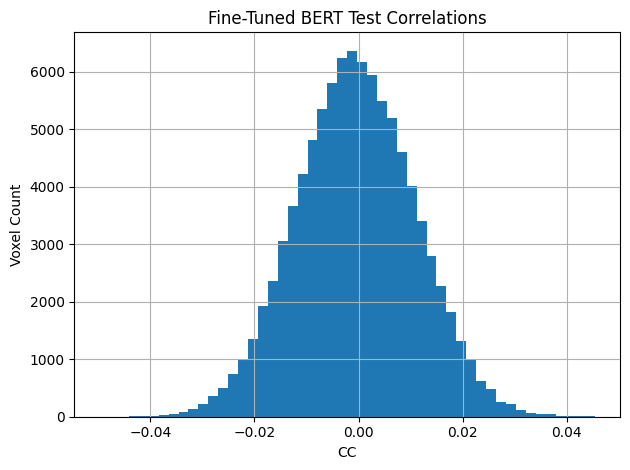

Mean CC: -0.0005614463464444009
Median CC: -0.0006361565271184793
Top 1% CC: 0.02569892682127592
Top 5% CC: 0.018177951367134272


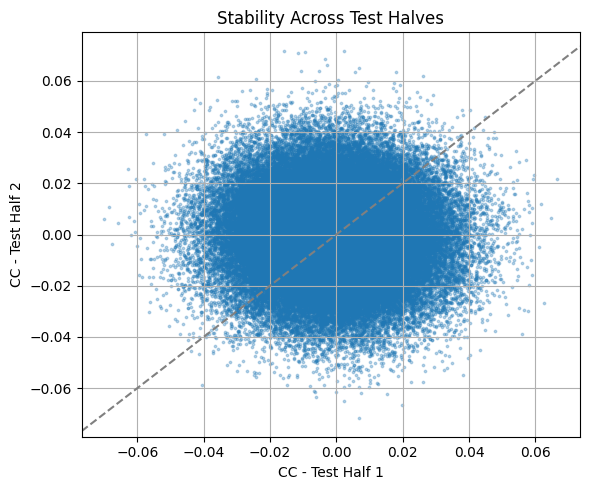

Stability (correlation of voxel CCs across halves): -0.02185978092578389


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# === Load fine-tuned model predictions and true responses ===
Y_pred = np.load(f"./bert-fmri-finetuned/test_predictions.npy")    # shape: [T, V]
# Reload true labels if needed, since test_loader might be exhausted
Y_true = []

with torch.no_grad():
    for batch in test_loader:
        Y_true.append(batch["y"].cpu().numpy())

Y_true = np.concatenate(Y_true, axis=0)


# === Compute voxel-wise correlations (CCs) ===
def voxel_cc(y_true, y_pred):
    return np.array([
        np.corrcoef(y_true[:, i], y_pred[:, i])[0, 1]
        for i in range(y_true.shape[1])
    ])

corrs = voxel_cc(Y_true, Y_pred)
corrs = np.nan_to_num(corrs)

# Save results
np.save("finetuned_weights.npy", model.head.weight.detach().cpu().numpy())
np.save("finetuned_corrs.npy", corrs)

# === Plot correlation histogram ===
plt.hist(corrs, bins=50)
plt.title("Fine-Tuned BERT Test Correlations")
plt.xlabel("CC")
plt.ylabel("Voxel Count")
plt.grid(True)
plt.tight_layout()
plt.show()

print("Mean CC:", np.mean(corrs))
print("Median CC:", np.median(corrs))
print("Top 1% CC:", np.percentile(corrs, 99))
print("Top 5% CC:", np.percentile(corrs, 95))

# === Stability: split test set in half by time ===
n = Y_true.shape[0]
half = n // 2
Y_pred_1 = Y_pred[:half]
Y_pred_2 = Y_pred[half:]
Y_true_1 = Y_true[:half]
Y_true_2 = Y_true[half:]

cc_1 = voxel_cc(Y_true_1, Y_pred_1)
cc_2 = voxel_cc(Y_true_2, Y_pred_2)
cc_1 = np.nan_to_num(cc_1)
cc_2 = np.nan_to_num(cc_2)

# === Plot stability scatter ===
plt.figure(figsize=(6, 5))
plt.scatter(cc_1, cc_2, alpha=0.3, s=3)
plt.xlabel("CC - Test Half 1")
plt.ylabel("CC - Test Half 2")
plt.title("Stability Across Test Halves")
plt.axline((0, 0), slope=1, linestyle="--", color="gray")
plt.grid(True)
plt.tight_layout()
plt.show()

stability_score = np.corrcoef(cc_1, cc_2)[0, 1]
print("Stability (correlation of voxel CCs across halves):", stability_score)
